<h2> A134 Team 9</h2><br />

### Team Members: Tyler Goh, Celyna Teo, Vamika Kakkar
### Dataset: [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
### Problem Statement: Predicting review scores to help flag down fake reviews

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import torch
from IPython.display import Image
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from catboost import CatBoostClassifier
pd.options.display.max_columns = None  # Shows all columns when printing a dataframe
sb.set()

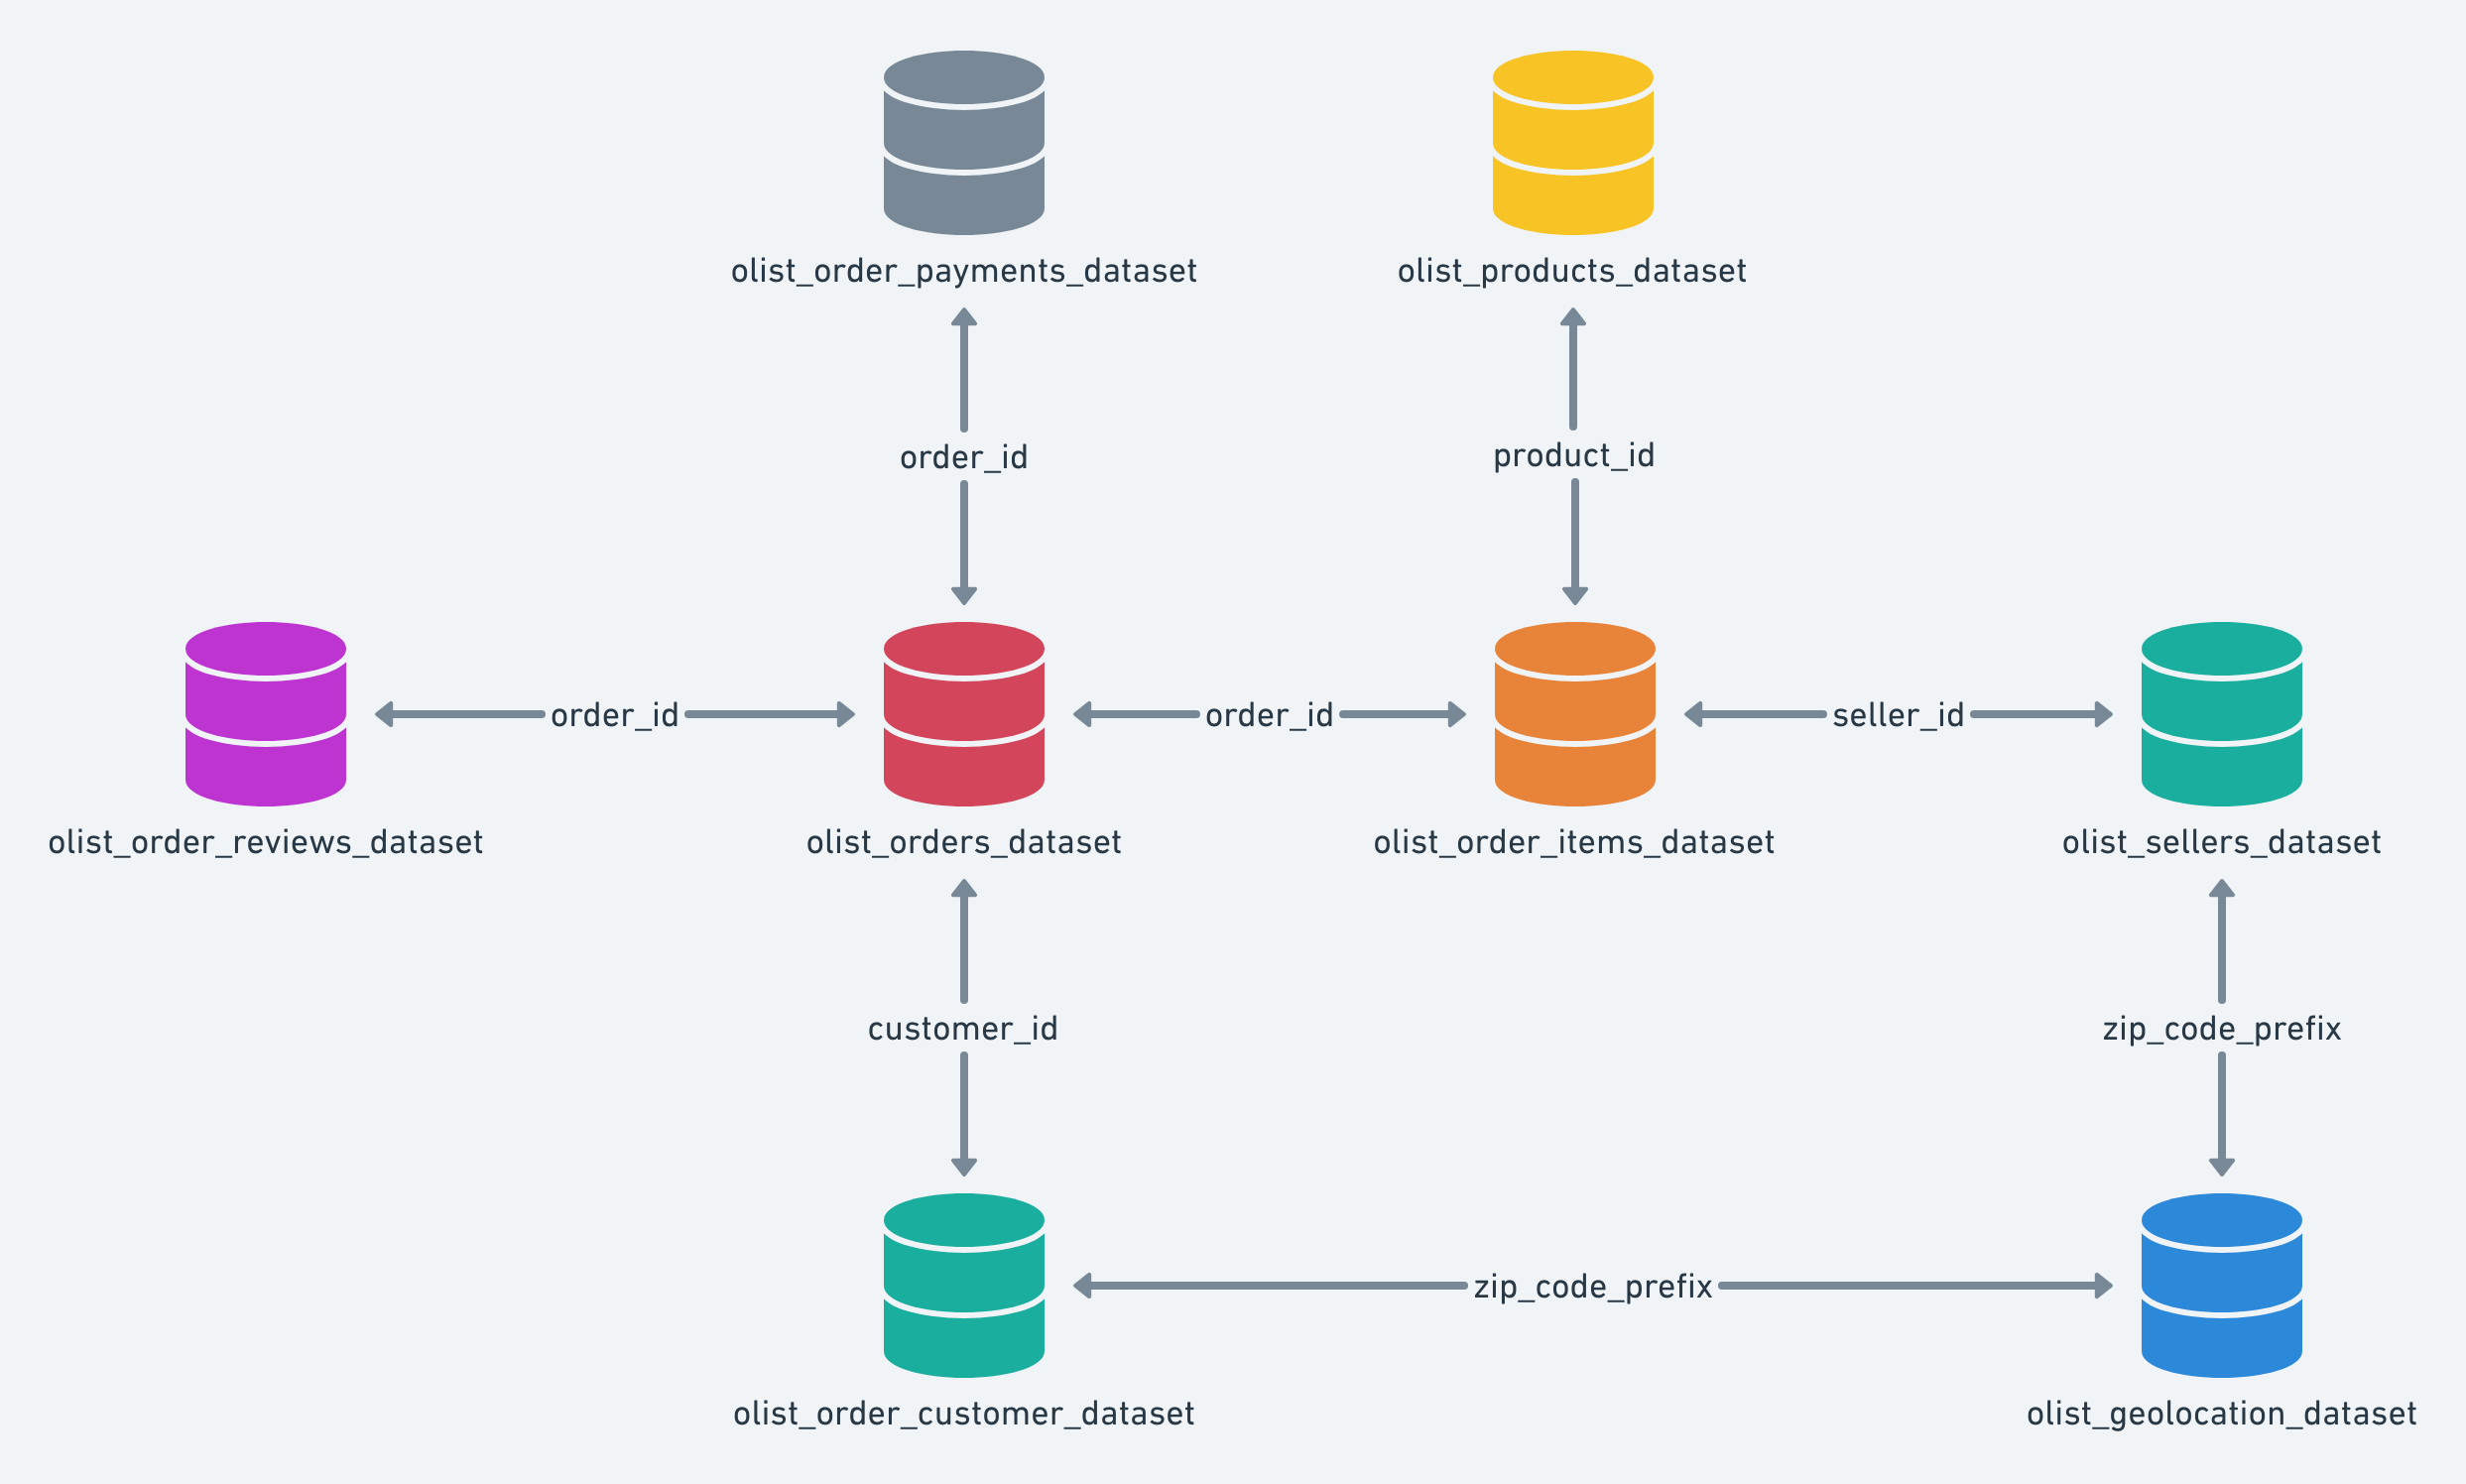

In [2]:
Image(filename='./data/dataschema.png', width=800, height=800)

In [3]:
Customers = pd.read_csv('./data/olist_customers_dataset.csv')
Geolocation = pd.read_csv('./data/olist_geolocation_dataset.csv')
Orders = pd.read_csv('./data/olist_orders_dataset.csv')
OrderItems = pd.read_csv('./data/olist_order_items_dataset.csv')
OrderPayments = pd.read_csv('./data/olist_order_payments_dataset.csv')
OrderReviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
Products = pd.read_csv('./data/olist_products_dataset.csv')
Sellers = pd.read_csv('./data/olist_sellers_dataset.csv')

### The geolocation database was linked to the order and seller dataset through the zip_code_prefix, however the key was not unique. 

### Each zip code had multiple latitude and longitudes but since they are all so similar we can just remove the duplicates.

In [4]:
Geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
Geolocation.drop_duplicates(subset=['geolocation_zip_code_prefix'], inplace=True)

In [6]:
print(Customers.info())
print(Geolocation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4

* <h3> Customers and Geolocation also have different columns names for zip code despite being the same field which must be renamed to match <h3>

In [7]:
Customers.rename(columns={"customer_zip_code_prefix": "zip_code"}
                 , inplace=True)
Geolocation.rename(columns={"geolocation_zip_code_prefix": "zip_code"}
                   , inplace=True)

### Merging all dataset based on database schema above

In [8]:
train_data = Customers.merge(Orders, on="customer_id")
train_data = train_data.merge(OrderReviews, on="order_id")
train_data = train_data.merge(OrderItems, on="order_id")
train_data = train_data.merge(OrderPayments, on="order_id")
train_data = train_data.merge(Products, on="product_id")
train_data = train_data.merge(Sellers, on="seller_id")
train_data = train_data.merge(Geolocation, on="zip_code", how="left")

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117329 non-null  object 
 1   customer_unique_id             117329 non-null  object 
 2   zip_code                       117329 non-null  int64  
 3   customer_city                  117329 non-null  object 
 4   customer_state                 117329 non-null  object 
 5   order_id                       117329 non-null  object 
 6   order_status                   117329 non-null  object 
 7   order_purchase_timestamp       117329 non-null  object 
 8   order_approved_at              117314 non-null  object 
 9   order_delivered_carrier_date   116094 non-null  object 
 10  order_delivered_customer_date  114858 non-null  object 
 11  order_estimated_delivery_date  117329 non-null  object 
 12  review_id                     

In [10]:
train_data.drop(columns=["review_comment_title",
                         "customer_id",
                         "customer_unique_id",
                         "zip_code",
                         "order_id",
                         "order_status",
                         "review_id",
                         'order_approved_at',
                         "review_creation_date",
                         "review_answer_timestamp",
                         "order_item_id",
                         'order_delivered_carrier_date',
                         "product_id",
                         "seller_id",
                         "shipping_limit_date",
                         "payment_sequential",
                         "payment_type",
                         "payment_installments",
                         "product_name_lenght",
                         "product_description_lenght",
                         "geolocation_city",
                         "geolocation_state",
                         "seller_zip_code_prefix"], inplace=True)

### We removed data that were not useful. 

### We also had to remove review_comment_title which would be useful but had too many null rows and cleaning the data would lead to too much information loss. 

### Now we can remove all the null rows from our dataset.

# ***DATA CLEANING***

In [11]:
cleaned_data = train_data.dropna().copy()
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47257 entries, 1 to 117322
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_city                  47257 non-null  object 
 1   customer_state                 47257 non-null  object 
 2   order_purchase_timestamp       47257 non-null  object 
 3   order_delivered_customer_date  47257 non-null  object 
 4   order_estimated_delivery_date  47257 non-null  object 
 5   review_score                   47257 non-null  int64  
 6   review_comment_message         47257 non-null  object 
 7   price                          47257 non-null  float64
 8   freight_value                  47257 non-null  float64
 9   payment_value                  47257 non-null  float64
 10  product_category_name          47257 non-null  object 
 11  product_photos_qty             47257 non-null  float64
 12  product_weight_g               47257 non-null

In [12]:
# Converting delivery times from string to datetime format
cleaned_data["order_purchase_timestamp"] = cleaned_data["order_purchase_timestamp"].astype('datetime64[ns]')
cleaned_data["order_delivered_customer_date"] = cleaned_data["order_delivered_customer_date"].astype('datetime64[ns]')
cleaned_data["order_estimated_delivery_date"] = cleaned_data["order_estimated_delivery_date"].astype('datetime64[ns]')
cleaned_data.tail()

,customer_city,customer_state,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state,geolocation_lat,geolocation_lng
117305,porto alegre,RS,2017-10-26 11:22:23,2017-11-08 22:04:00,2017-11-23,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,20.0,20.0,20.0,sao paulo,SP,-30.144365,-51.126372
117306,porto alegre,RS,2017-10-26 11:22:23,2017-11-08 22:04:00,2017-11-23,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,20.0,20.0,20.0,sao paulo,SP,-30.144365,-51.126372
117319,porto velho,RO,2018-04-30 16:52:39,2018-05-21 17:28:51,2018-06-01,5,Parabéns gostei de ter comprado na lojas lanni...,168.10,37.55,205.65,construcao_ferramentas_construcao,1.0,4650.0,45.0,22.0,45.0,sao paulo,SP,-8.753067,-63.908460
117321,parnamirim,RN,2018-08-16 15:02:31,2018-08-28 22:08:29,2018-09-24,4,Estou mais que impressionado com a rapidez da ...,1750.00,39.02,1789.02,beleza_saude,1.0,1100.0,20.0,10.0,15.0,niteroi,RJ,-5.882257,-35.204034
117322,barreiras,BA,2018-07-20 09:42:40,2018-07-27 11:54:15,2018-08-14,5,"Ótimo produto, entrega rápida, superou minhas ...",145.90,15.47,161.37,bebidas,1.0,2250.0,16.0,28.0,16.0,salvador,BA,-12.147031,-44.996092


# ***DATA EXTRACTION***

### Right now the purchase time, delivered time and estimated delivery time won't be meaningful to the machine learning algorithm hence we created new columns that would make sense of the columns. 

### Columns added:

### 1. days_to_deliver is the difference between purchasing date and the delivery date. 

### 2. days_before_estimated_delivery is the difference between the estimated delivery date and the actual delivery date

In [13]:
# Creating new features based on current features
feature_data = cleaned_data.copy()
feature_data['days_to_deliver'] = (feature_data['order_delivered_customer_date'] - feature_data['order_purchase_timestamp']).dt.days
feature_data['days_before_estimated_delivery'] = (feature_data['order_estimated_delivery_date'] - feature_data['order_delivered_customer_date']).dt.days
feature_data.drop(columns=["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"], inplace=True)

In [14]:
feature_data.tail()

,customer_city,customer_state,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state,geolocation_lat,geolocation_lng,days_to_deliver,days_before_estimated_delivery
117305,porto alegre,RS,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,20.0,20.0,20.0,sao paulo,SP,-30.144365,-51.126372,13,14
117306,porto alegre,RS,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,20.0,20.0,20.0,sao paulo,SP,-30.144365,-51.126372,13,14
117319,porto velho,RO,5,Parabéns gostei de ter comprado na lojas lanni...,168.10,37.55,205.65,construcao_ferramentas_construcao,1.0,4650.0,45.0,22.0,45.0,sao paulo,SP,-8.753067,-63.908460,21,10
117321,parnamirim,RN,4,Estou mais que impressionado com a rapidez da ...,1750.00,39.02,1789.02,beleza_saude,1.0,1100.0,20.0,10.0,15.0,niteroi,RJ,-5.882257,-35.204034,12,26
117322,barreiras,BA,5,"Ótimo produto, entrega rápida, superou minhas ...",145.90,15.47,161.37,bebidas,1.0,2250.0,16.0,28.0,16.0,salvador,BA,-12.147031,-44.996092,7,17


### To try to make the data more meaningful the product length, height and width was converted to volume

In [15]:
def get_volume(row):
    volume = row["product_length_cm"] * row["product_height_cm"] * row["product_width_cm"]
    return pd.Series(volume)


feature_data[['volume']] = feature_data.apply(get_volume, axis=1)
feature_data.drop(columns=["product_length_cm", "product_height_cm", "product_width_cm"], inplace=True)
feature_data.tail()

,customer_city,customer_state,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,seller_city,seller_state,geolocation_lat,geolocation_lng,days_to_deliver,days_before_estimated_delivery,volume
117305,porto alegre,RS,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,sao paulo,SP,-30.144365,-51.126372,13,14,8000.0
117306,porto alegre,RS,1,"comprei 5 kg de bicarbonato, mas foram entregu...",7.45,14.10,107.75,beleza_saude,2.0,1200.0,sao paulo,SP,-30.144365,-51.126372,13,14,8000.0
117319,porto velho,RO,5,Parabéns gostei de ter comprado na lojas lanni...,168.10,37.55,205.65,construcao_ferramentas_construcao,1.0,4650.0,sao paulo,SP,-8.753067,-63.908460,21,10,44550.0
117321,parnamirim,RN,4,Estou mais que impressionado com a rapidez da ...,1750.00,39.02,1789.02,beleza_saude,1.0,1100.0,niteroi,RJ,-5.882257,-35.204034,12,26,3000.0
117322,barreiras,BA,5,"Ótimo produto, entrega rápida, superou minhas ...",145.90,15.47,161.37,bebidas,1.0,2250.0,salvador,BA,-12.147031,-44.996092,7,17,7168.0


# ***DATA NORMALIZATION***

### Some columns such as product weight and product volume are of greater magnitude compared to columns such as photo quantity.

### This won't be a problem using decision trees but may skew other regression models hence we normalize most of our columns from 0 to 1

In [16]:
def normalize_column(data, maximum=1):
    data_min = data.min()[0]
    data_max = data.max()[0]
    new_min = 0
    new_max = maximum
    mapper = lambda x: ((x - data_min) / (data_max - data_min)) * (new_max - new_min) + new_min
    return data.apply(mapper)


normalized_data = feature_data.copy()
normalized_data["volume"] = normalize_column(normalized_data[["volume"]])
normalized_data["product_weight_g"] = normalize_column(normalized_data[["product_weight_g"]])
normalized_data["payment_value"] = normalize_column(normalized_data[["payment_value"]])
normalized_data["freight_value"] = normalize_column(normalized_data[["freight_value"]])
normalized_data["price"] = normalize_column(normalized_data[["price"]])
normalized_data.head()

,customer_city,customer_state,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,seller_city,seller_state,geolocation_lat,geolocation_lng,days_to_deliver,days_before_estimated_delivery,volume
1,santarem,PA,1,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,-2.442747,-54.728950,18,20,0.371633
2,santarem,PA,1,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,-2.442747,-54.728950,18,20,0.371633
3,nova santa rita,RS,3,"Produto compatível com seu valor, muito bonito...",0.018434,0.041622,0.010290,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,-29.856534,-51.268958,18,16,0.371633
4,mage,RJ,4,Entregou antes do prazo,0.015761,0.081512,0.010069,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,-22.627556,-43.159942,25,21,0.371633
6,contagem,MG,4,Os encaixes para o encosto da cadeira estavam ...,0.018434,0.081832,0.011395,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,-19.934105,-44.058950,13,8,0.371633


### Latitude and Longitude is a special case where we want to preserve their shape relative to each other

### To do this we scale these features based on the largest range between the two

In [17]:
latitude = normalized_data[['geolocation_lat']]
longitude = normalized_data[['geolocation_lng']]
lat_range = latitude.max()[0] - latitude.min()[0]
long_range = longitude.max()[0] - longitude.min()[0]
max_range = max(lat_range, long_range)
print(f"Latitude range: {lat_range}, Longitude range: {long_range}")

normalized_data["longitude"] = normalize_column(longitude, maximum=lat_range/max_range)
normalized_data["latitude"] = normalize_column(latitude, maximum=lat_range/max_range)
normalized_data.drop(columns=["geolocation_lat", "geolocation_lng"], inplace=True)
normalized_data.head()

Latitude range: 78.78937715369207, Longitude range: 64.08885053080984


,customer_city,customer_state,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,seller_city,seller_state,days_to_deliver,days_before_estimated_delivery,volume,longitude,latitude
1,santarem,PA,1,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594
2,santarem,PA,1,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594
3,nova santa rita,RS,3,"Produto compatível com seu valor, muito bonito...",0.018434,0.041622,0.010290,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,16,0.371633,0.333876,0.085657
4,mage,RJ,4,Entregou antes do prazo,0.015761,0.081512,0.010069,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,25,21,0.371633,0.460404,0.177407
6,contagem,MG,4,Os encaixes para o encosto da cadeira estavam ...,0.018434,0.081832,0.011395,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,13,8,0.371633,0.446376,0.211593


### The review comments should give big hint about the review score for this we will be using a pretrained sentiment analysis model.

### The model we will be using is [FinBERT-PT-BR](https://huggingface.co/lucas-leme/FinBERT-PT-BR)

### It returns 3 fields Postive, Neutral, Negative and each field will have a probability that its true with negative being very sure its not true


In [18]:
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
finbertptbr = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")


def apply_sentiment(row):
    tokens = tokenizer([row["review_comment_message"]], return_tensors="pt",
                       padding=True, truncation=True, max_length=512)
    output = finbertptbr(**tokens).logits.cpu().detach().numpy()[0]
    return pd.Series([output[0], output[1], output[2]])


normalized_data[['Postive', 'Negative', 'Neutral']] = normalized_data.apply(apply_sentiment, axis=1)
normalized_data.drop(columns=["review_comment_message"], inplace=True)
normalized_data.to_csv('sentiment_applied_data.csv')
normalized_data.head()

,customer_city,customer_state,review_score,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,seller_city,seller_state,days_to_deliver,days_before_estimated_delivery,volume,longitude,latitude,Postive,Negative,Neutral
1,santarem,PA,1,0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594,-1.206630,-1.055449,0.678881
2,santarem,PA,1,0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594,-1.206630,-1.055449,0.678881
3,nova santa rita,RS,3,0.018434,0.041622,0.010290,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,16,0.371633,0.333876,0.085657,0.953789,-1.557359,-0.898815
4,mage,RJ,4,0.015761,0.081512,0.010069,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,25,21,0.371633,0.460404,0.177407,-1.083382,-0.363806,-0.075252
6,contagem,MG,4,0.018434,0.081832,0.011395,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,13,8,0.371633,0.446376,0.211593,-1.839454,1.374050,-1.462928


### There is a need to save the file as 1 row takes about 0.05ms to process meaning it takes approximately ~33min to process all the rows above

In [19]:
normalized_data = pd.read_csv('sentiment_applied_data.csv', index_col=0)
normalized_data.corr()

/tmp/ipykernel_57443/2572843361.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_data.corr()


,review_score,price,freight_value,payment_value,product_photos_qty,product_weight_g,days_to_deliver,days_before_estimated_delivery,volume,longitude,latitude,Postive,Negative,Neutral
review_score,1.000000,0.009491,-0.026840,-0.092061,0.035526,-0.024213,-0.292895,0.229899,-0.023177,-0.027287,-0.005413,0.686070,-0.563660,0.097981
price,0.009491,1.000000,0.414176,0.686674,0.060822,0.350433,0.062782,-0.005942,0.314057,0.021432,0.057158,-0.006063,0.007565,-0.014210
freight_value,-0.026840,0.414176,1.000000,0.354974,0.028455,0.621106,0.196157,0.027676,0.593946,0.098434,0.272461,-0.032026,0.035142,-0.016978
payment_value,-0.092061,0.686674,0.354974,1.000000,0.011339,0.294937,0.047268,0.025119,0.267548,0.015505,0.054782,-0.080177,0.040395,0.014711
product_photos_qty,0.035526,0.060822,0.028455,0.011339,1.000000,0.022290,-0.032120,0.000179,0.011557,0.006994,0.032414,0.034527,-0.019281,-0.007239
product_weight_g,-0.024213,0.350433,0.621106,0.294937,0.022290,1.000000,0.081376,-0.012205,0.811294,-0.000778,-0.003316,-0.023361,0.032032,-0.035486
days_to_deliver,-0.292895,0.062782,0.196157,0.047268,-0.032120,0.081376,1.000000,-0.660851,0.074823,0.126663,0.250147,-0.241707,0.233000,-0.052622
days_before_estimated_delivery,0.229899,-0.005942,0.027676,0.025119,0.000179,-0.012205,-0.660851,1.000000,-0.014607,-0.061126,0.002981,0.190831,-0.191277,0.044650
volume,-0.023177,0.314057,0.593946,0.267548,0.011557,0.811294,0.074823,-0.014607,1.000000,-0.010137,-0.011758,-0.018127,0.024941,-0.032406
longitude,-0.027287,0.021432,0.098434,0.015505,0.006994,-0.000778,0.126663,-0.061126,-0.010137,1.000000,0.454509,-0.028256,0.030714,-0.014940


In [20]:
encoded_data = normalized_data.copy()
encoded_data

,customer_city,customer_state,review_score,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,seller_city,seller_state,days_to_deliver,days_before_estimated_delivery,volume,longitude,latitude,Postive,Negative,Neutral
1,santarem,PA,1,0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594,-1.206630,-1.055449,0.678881
2,santarem,PA,1,0.016652,0.066350,0.020184,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,20,0.371633,0.279889,0.433594,-1.206630,-1.055449,0.678881
3,nova santa rita,RS,3,0.018434,0.041622,0.010290,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,18,16,0.371633,0.333876,0.085657,0.953789,-1.557359,-0.898815
4,mage,RJ,4,0.015761,0.081512,0.010069,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,25,21,0.371633,0.460404,0.177407,-1.083382,-0.363806,-0.075252
6,contagem,MG,4,0.018434,0.081832,0.011395,moveis_escritorio,1.0,0.289433,itaquaquecetuba,SP,13,8,0.371633,0.446376,0.211593,-1.839454,1.374050,-1.462928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117305,porto alegre,RS,1,0.000980,0.037572,0.007886,beleza_saude,2.0,0.040000,sao paulo,SP,13,14,0.027210,0.336101,0.082004,-1.232417,-0.868377,0.000223
117306,porto alegre,RS,1,0.000980,0.037572,0.007886,beleza_saude,2.0,0.040000,sao paulo,SP,13,14,0.027210,0.336101,0.082004,-1.232417,-0.868377,0.000223
117319,porto velho,RO,5,0.024836,0.100059,0.015050,construcao_ferramentas_construcao,1.0,0.155000,sao paulo,SP,21,10,0.154194,0.136658,0.353503,0.024852,-1.374854,-0.350873
117321,parnamirim,RN,4,0.259743,0.103976,0.130929,beleza_saude,1.0,0.036667,niteroi,RJ,12,26,0.009839,0.584543,0.389940,-1.207441,-0.799562,-0.272629


## Catogorical data such as customer_city can be converted into numerical data through label encoding or one hot encoding

## We opt to use one hot encoding as label encoding might introduce bias

In [21]:
def oneHotEncode(data, column):
    data[column].str.replace(" ", "")
    newColumns = pd.get_dummies(data[column], prefix=column+"_")
    data = pd.concat([data, newColumns], axis=1)
    return data


encoded_data = oneHotEncode(encoded_data, "customer_city")
encoded_data = oneHotEncode(encoded_data, "customer_state")
encoded_data = oneHotEncode(encoded_data, "seller_state")
encoded_data = oneHotEncode(encoded_data, "seller_city")
encoded_data = oneHotEncode(encoded_data, "product_category_name")
encoded_data.drop(columns=["customer_city",
                           "customer_state",
                           "seller_state",
                           "seller_city",
                           "product_category_name"], inplace=True)
encoded_data.head()

review_score     price  freight_value  payment_value  product_photos_qty  \
1             1  0.016652       0.066350       0.020184                 1.0   
2             1  0.016652       0.066350       0.020184                 1.0   
3             3  0.018434       0.041622       0.010290                 1.0   
4             4  0.015761       0.081512       0.010069                 1.0   
6             4  0.018434       0.081832       0.011395                 1.0   

   product_weight_g  days_to_deliver  days_before_estimated_delivery  \
1          0.289433               18                              20   
2          0.289433               18                              20   
3          0.289433               18                              16   
4          0.289433               25                              21   
6          0.289433               13                               8   

     volume  longitude  latitude   Postive  Negative   Neutral  \
1  0.371633   0.279889  0.433594 -1.206630 -1.055449  0.678881   
2  0.371633   0.279889  0.433594 -1.206630 -1.055449  0.678881   
3  0.371633   0.333876  0.085657  0.953789 -1.557359 -0.898815   
4  0.371633   0.460404  0.177407 -1.083382 -0.363806 -0.075252   
6  0.371633   0.446376  0.211593 -1.839454  1.374050 -1.462928   

   customer_city__abadia dos dourados  customer_city__abaete  \
1                                   0                      0   
2                                   0                      0   
3                                   0                      0   
4                                   0                      0   
6                                   0                      0   

   customer_city__abaetetuba  customer_city__abaiara  customer_city__abare  \
1                          0                       0                     0   
2                          0                       0                     0   
3                          0                       0                     0   
4                          0                       0                     0   
6                          0                       0                     0   

   customer_city__abatia  customer_city__abelardo luz  \
1                      0                            0   
2                      0                            0   
3                      0                            0   
4                      0                            0   
6                      0                            0   

   customer_city__abrantes  customer_city__abre campo  \
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   
6                        0                          0   

   customer_city__abreu e lima  customer_city__acailandia  \
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   
6                            0                          0   

   customer_city__acarau  customer_city__acegua  customer_city__acopiara  \
1                      0                      0                        0   
2                      0                      0                        0   
3                      0                      0                        0   
4                      0                      0                        0   
6                      0                      0                        0   

   customer_city__acreuna  customer_city__acu  customer_city__adamantina  \
1                       0                   0                          0   
2                       0                   0                          0   
3                       0                   0                          0   
4                       0     

# ***MACHINE LEARNING***

### We firstly tried to use a decision tree with a depth of 10 to find out the review score

In [22]:
y = encoded_data[["review_score"]]
X = encoded_data.drop(columns=["review_score"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dectree = DecisionTreeClassifier(max_depth=10)
dectree.fit(X_train, y_train)
print("-")

-


### Checking accuracy of decision tree

In [23]:
score = dectree.score(X_test, y_test)
print(f'The accuracy is {score*100:.2f}%')

The accuracy is 66.07%


### Next we tried a external library called Catboost

### The maximum depth we could set it to was 13 as our data had too many features

In [24]:
modelcat = CatBoostClassifier(iterations=30,
                              learning_rate=1,
                              depth=13)
modelcat.fit(X_train, y_train)

0:	learn: 1.0905999	total: 1.42s	remaining: 41.2s
1:	learn: 0.9978045	total: 2.81s	remaining: 39.3s
2:	learn: 0.9533875	total: 4.21s	remaining: 37.9s
3:	learn: 0.8945103	total: 5.61s	remaining: 36.5s
4:	learn: 0.8631737	total: 7.1s	remaining: 35.5s
5:	learn: 0.7929199	total: 8.54s	remaining: 34.2s
6:	learn: 0.7689382	total: 9.95s	remaining: 32.7s
7:	learn: 0.7614026	total: 11.3s	remaining: 31.2s
8:	learn: 0.7334746	total: 12.7s	remaining: 29.7s
9:	learn: 0.7106532	total: 14.1s	remaining: 28.2s
10:	learn: 0.7053660	total: 15.5s	remaining: 26.7s
11:	learn: 0.6944412	total: 16.9s	remaining: 25.3s
12:	learn: 0.6903249	total: 18.2s	remaining: 23.9s
13:	learn: 0.6875873	total: 19.6s	remaining: 22.4s
14:	learn: 0.6801739	total: 21s	remaining: 21s
15:	learn: 0.6695623	total: 22.4s	remaining: 19.6s
16:	learn: 0.6550530	total: 23.7s	remaining: 18.1s
17:	learn: 0.6539740	total: 25.1s	remaining: 16.7s
18:	learn: 0.6536650	total: 26.5s	remaining: 15.3s
19:	learn: 0.6410188	total: 27.8s	remaining: 1

### Checking accuracy of gradient boosted random forest regression with depth 13 and one-hot encoding

In [25]:
y_pred = modelcat.predict(X_test)
y_pred = (np.rint(y_pred)).astype(int)
score = accuracy_score(y_pred, y_test)
print(f'The accuracy is {score*100:.2f}%')

The accuracy is 66.64%


### By removing one hot encoding we were able to increase our depth, and with the increase in depth our accuracy increased

In [26]:
y = normalized_data[["review_score",]]
X = normalized_data.drop(columns=["review_score", "customer_city", "customer_state", "seller_state", "seller_city", "product_category_name"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
modelcat = CatBoostClassifier(iterations=30,
                              learning_rate=1,
                              depth=16)
modelcat.fit(X_train, y_train)

0:	learn: 1.0356026	total: 8.47s	remaining: 4m 5s
1:	learn: 0.8993774	total: 14.7s	remaining: 3m 25s
2:	learn: 0.7988456	total: 20.6s	remaining: 3m 5s
3:	learn: 0.7264520	total: 25.9s	remaining: 2m 48s
4:	learn: 0.6748851	total: 31.1s	remaining: 2m 35s
5:	learn: 0.6315630	total: 36.7s	remaining: 2m 26s
6:	learn: 0.5734505	total: 41.6s	remaining: 2m 16s
7:	learn: 0.5255178	total: 46.4s	remaining: 2m 7s
8:	learn: 0.4809831	total: 51.5s	remaining: 2m
9:	learn: 0.4457606	total: 56.5s	remaining: 1m 53s
10:	learn: 0.4096158	total: 1m 1s	remaining: 1m 46s
11:	learn: 0.3893807	total: 1m 6s	remaining: 1m 39s
12:	learn: 0.3618446	total: 1m 11s	remaining: 1m 33s
13:	learn: 0.3423680	total: 1m 16s	remaining: 1m 27s
14:	learn: 0.3262326	total: 1m 21s	remaining: 1m 21s
15:	learn: 0.3076928	total: 1m 26s	remaining: 1m 15s
16:	learn: 0.2889916	total: 1m 31s	remaining: 1m 9s
17:	learn: 0.2711697	total: 1m 35s	remaining: 1m 3s
18:	learn: 0.2574751	total: 1m 40s	remaining: 58.4s
19:	learn: 0.2481206	tota

### Checking accuracy of gradient boosted decision tree with depth 16

In [27]:
y_pred = modelcat.predict(X_test)
y_pred = (np.rint(y_pred)).astype(int)
score = accuracy_score(y_pred, y_test)
print(f'The accuracy is {score*100:.2f}%')

The accuracy is 69.15%


In [28]:
y_train_onehot = pd.get_dummies(y_train.loc[:, 'review_score'])
y_train_onehot

,1,2,3,4,5
106354,0,0,0,0,1
69167,0,0,0,0,1
79692,0,0,0,0,1
6453,0,0,0,1,0
88166,0,0,1,0,0
...,...,...,...,...,...
1255,1,0,0,0,0
87408,0,0,0,1,0
531,0,0,1,0,0
26215,0,0,0,0,1


In [29]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy().astype(np.float32))
        self.y = torch.tensor(y.to_numpy().astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


train_data = Data(X_train, y_train_onehot)
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
print(train_data.X)
print(train_data.y)

tensor([[ 1.4315e-03,  2.2037e-02,  1.3729e-03,  ..., -4.9745e-01,
         -1.3665e+00,  1.8562e-01],
        [ 1.0996e-02,  4.5193e-02,  6.7227e-03,  ..., -1.3237e+00,
         -1.2257e+00,  7.7203e-01],
        [ 3.7528e-02,  1.0310e-01,  2.1389e-02,  ...,  9.3208e-01,
         -1.5614e+00, -7.7486e-01],
        ...,
        [ 1.0267e-02,  6.1821e-02,  2.0460e-02,  ..., -9.4474e-01,
         -9.6843e-01,  4.7789e-01],
        [ 1.3818e-02,  2.5208e-02,  7.5644e-03,  ...,  7.0832e-01,
         -9.2450e-01, -4.7838e-01],
        [ 1.4709e-02,  0.0000e+00,  7.3111e-03,  ..., -9.0707e-01,
         -1.2377e+00, -7.2848e-02]])
tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])


In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 130)
        self.fc2 = nn.Linear(130, 65)
        self.fc3 = nn.Linear(65, 39)
        self.fc4 = nn.Linear(39, 5)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sm(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
    running_loss = 0.0

print(outputs[0:3])
print(y[0:3])
print('Finished Training')

[1] loss: 0.774
[2] loss: 0.757
[3] loss: 0.755
[4] loss: 0.748
[5] loss: 0.712
[6] loss: 0.706
[7] loss: 0.704
[8] loss: 0.703
[9] loss: 0.702
[10] loss: 0.701
[11] loss: 0.701
[12] loss: 0.701
[13] loss: 0.701
[14] loss: 0.700
[15] loss: 0.700
[16] loss: 0.700
[17] loss: 0.700
[18] loss: 0.700
[19] loss: 0.699
[20] loss: 0.700
[21] loss: 0.699
[22] loss: 0.699
[23] loss: 0.699
[24] loss: 0.699
[25] loss: 0.699
[26] loss: 0.699
[27] loss: 0.699
[28] loss: 0.699
[29] loss: 0.699
[30] loss: 0.699
tensor([[9.9999e-01, 8.9907e-07, 2.4505e-06, 4.3225e-06, 1.4273e-06],
        [5.3459e-08, 1.4718e-08, 1.7608e-08, 2.0918e-08, 1.0000e+00],
        [9.0170e-05, 2.2248e-07, 4.5734e-07, 5.6145e-07, 9.9991e-01]],
       grad_fn=<SliceBackward0>)
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])
Finished Training


### Checking accuracy of neural network

In [32]:
outputs = net(torch.tensor(X_test.to_numpy().astype(np.float32)))
_, y_pred = torch.max(outputs.data, 1)
score = accuracy_score(y_pred+1, y_test)
print(f'The accuracy is {score*100:.2f}%')

The accuracy is 64.05%


# ***APPLICATION***
## Attempt to detect fake reviews by seeing which review_score has a difference greater than 2 compared to our predicted score

In [33]:
sample_data = normalized_data.copy()
sample_data.drop(columns=["customer_city", "customer_state", "seller_state", "seller_city", "product_category_name"], inplace=True)


def apply_prediction(row):
    output = modelcat.predict(row)
    return pd.Series(output)


sample_data[['Predicted']] = sample_data.drop(columns="review_score").apply(apply_prediction, axis=1)

In [35]:
pd.options.display.max_colwidth = None  # Expand all fields when printing a dataframe
flagged_reviews = cleaned_data[abs(sample_data['Predicted'] - sample_data['review_score']) > 2]
flagged_reviews.head(20)

,customer_city,customer_state,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,price,freight_value,payment_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state,geolocation_lat,geolocation_lng
182,campinas,SP,2018-03-05 20:34:23,2018-03-22 20:27:41,2018-04-02,1,Cumpriu com excelência,116.60,19.99,136.59,moveis_escritorio,1.0,2600.0,40.0,45.0,39.0,itaquaquecetuba,SP,-22.932218,-47.096790
360,franca,SP,2017-07-23 12:08:53,2017-08-07 15:43:27,2017-08-17,5,"O produto foi entregue antes do prazo combinado, muito Bom!. só tenho uma reclamação, me mandaram o manual de montagem do produto diferente do qual eu recebi",209.99,36.98,246.97,moveis_escritorio,2.0,17050.0,63.0,62.0,24.0,itaquaquecetuba,SP,-20.506794,-47.407738
491,taboao da serra,SP,2018-01-10 19:10:18,2018-01-26 20:51:40,2018-02-09,4,Porém com alguns arranhões e danos.,136.99,37.05,174.04,moveis_escritorio,1.0,15475.0,81.0,7.0,83.0,itaquaquecetuba,SP,-23.625273,-46.779491
492,taboao da serra,SP,2017-10-18 20:24:45,2017-10-27 15:27:56,2017-11-06,4,"Deixou a desejar que a escrivaninha não veio c/ parafusos p/ colocar a tampa, tem apenas p/ os cavaletes.O fabricante tem q enviar todos os itens que o produto precisa para ser utilizado corretamente.",146.99,35.19,182.18,moveis_escritorio,1.0,15475.0,81.0,7.0,83.0,itaquaquecetuba,SP,-23.599804,-46.767305
527,ubatuba,SP,2018-04-13 09:29:56,2018-04-25 14:52:17,2018-05-10,5,Gosto de acompanhar o pedido e essa empresa nos fornece esse recurso.,69.99,33.33,103.32,moveis_escritorio,1.0,10075.0,55.0,64.0,26.0,itaquaquecetuba,SP,-23.431627,-45.077229
549,valparaiso de goias,GO,2017-06-30 18:12:15,2017-07-20 18:29:31,2017-08-03,5,A única coisa que desagradou foi que as os parafusos vieram soltos e caixa estava amassada e rasgada. Não colocaram em um saco plástico simples.,144.94,30.85,175.79,moveis_escritorio,1.0,8217.0,52.0,52.0,17.0,itaquaquecetuba,SP,-16.067796,-47.972388
553,barueri,SP,2018-03-30 19:08:13,2018-04-16 23:12:03,2018-04-27,1,recebi porem.embalagem ruim...mal acondicionada ..as rodas n giram..encosto c.defeito..odiei,139.94,18.35,158.29,moveis_escritorio,1.0,8217.0,52.0,52.0,17.0,itaquaquecetuba,SP,-23.495901,-46.874687
594,nova iguacu,RJ,2018-01-13 21:57:41,2018-02-07 01:12:02,2018-03-02,5,"Estou achando muito demorado há entrega, ficaram de me entregar até o dia 02/02/18 e até hoje não chegou",139.99,28.34,168.33,moveis_escritorio,1.0,9725.0,53.0,52.0,17.0,itaquaquecetuba,SP,-22.709328,-43.461049
659,petropolis,RJ,2017-05-07 14:06:36,2017-05-20 09:11:12,2017-05-31,4,Otima a cadeira.. o problema foi que veio muito suja!,176.99,45.70,222.69,moveis_escritorio,1.0,11875.0,57.0,55.0,22.0,itaquaquecetuba,SP,-22.511952,-43.177712
725,blumenau,SC,2017-12-05 01:53:56,2018-01-05 21:43:31,2018-01-16,2,Produto não se parece com a foto.,196.99,70.26,267.25,moveis_escritorio,2.0,16150.0,63.0,62.0,24.0,itaquaquecetuba,SP,-26.882803,-49.107613
